### Imports

In [75]:
from tqdm import tqdm
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# !pip install gym
# !pip install gym-anytrading
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 

# !pip install stable-baselines3
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback

import torch
import quantstats as qs

In [76]:
import yfinance as yf

# Download Tesla's stock data
# data = yf.download('TSLA', start='2020-01-01', end='2020-03-31')
# data = yf.download('TSLA', end='2022-12-31')
data = yf.download('MSFT', end='2022-12-31')
# data = data[:200]

[*********************100%%**********************]  1 of 1 completed


In [77]:
from imp import reload
from gym_anytrading.envs import stocks_env
from gym_anytrading.envs import trading_env

reload(stocks_env)
# reload(trading_env)

<module 'gym_anytrading.envs.stocks_env' from 'C:\\Users\\Steven\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\gym_anytrading\\envs\\stocks_env.py'>

### Create Env

In [78]:
window_size = 100  # Number of past observations the agent can see
frame_bound = (window_size, len(data))

# env = MyStocksEnv(prices, signal_features, df=data, window_size=30, frame_bound=(30, len(data)))
env = StocksEnv(df=data, window_size=window_size, frame_bound=frame_bound)
env

In [53]:
env._process_data()

(array([9.72220e-02, 1.00694e-01, 1.02431e-01, ..., 2.34530e+02,
        2.41010e+02, 2.39820e+02], dtype=float32),
 array([[ 9.7222000e-02,  0.0000000e+00],
        [ 1.0069400e-01,  3.4720004e-03],
        [ 1.0243100e-01,  1.7369986e-03],
        ...,
        [ 2.3453000e+02, -2.4300079e+00],
        [ 2.4100999e+02,  6.4799957e+00],
        [ 2.3982001e+02, -1.1899872e+00]], dtype=float32))

In [54]:
print("> signal_features.shape:", env.signal_features.shape)

> signal_features.shape: (9277, 2)


In [55]:
env.signal_features

array([[ 9.7222000e-02,  0.0000000e+00],
       [ 1.0069400e-01,  3.4720004e-03],
       [ 1.0243100e-01,  1.7369986e-03],
       ...,
       [ 2.3453000e+02, -2.4300079e+00],
       [ 2.4100999e+02,  6.4799957e+00],
       [ 2.3982001e+02, -1.1899872e+00]], dtype=float32)

In [56]:
env.prices

array([9.72220e-02, 1.00694e-01, 1.02431e-01, ..., 2.34530e+02,
       2.41010e+02, 2.39820e+02], dtype=float32)

In [57]:
env_name = 'stocks-v0' 
# # # env_name = 'forex-v0'
# env = gym.make(env_name)
# env

In [58]:
env._process_data()

(array([9.72220e-02, 1.00694e-01, 1.02431e-01, ..., 2.34530e+02,
        2.41010e+02, 2.39820e+02], dtype=float32),
 array([[ 9.7222000e-02,  0.0000000e+00],
        [ 1.0069400e-01,  3.4720004e-03],
        [ 1.0243100e-01,  1.7369986e-03],
        ...,
        [ 2.3453000e+02, -2.4300079e+00],
        [ 2.4100999e+02,  6.4799957e+00],
        [ 2.3982001e+02, -1.1899872e+00]], dtype=float32))

### Define Functions

In [59]:
def print_stats(reward_over_episodes):
    """  Print Reward  """

    avg = np.mean(reward_over_episodes)
    min = np.min(reward_over_episodes)
    max = np.max(reward_over_episodes)

    print (f'Min. Reward          : {min:>10.3f}')
    print (f'Avg. Reward          : {avg:>10.3f}')
    print (f'Max. Reward          : {max:>10.3f}')

    return min, avg, max


# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):
    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()


# TRAINING + TEST
def train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps=10_000):
    """ if model=None then execute 'Random actions' """

    # reproduce training and test
    print('-' * 80)
    obs = env.reset(seed=seed)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    vec_env = None

    if model is not None:
        print("model is not None")
        print(f'model {type(model)}')
        print(f'policy {type(model.policy)}')
        # print(f'model.learn(): {total_learning_timesteps} timesteps ...')

        # custom callback for 'progress_bar'
        model.learn(total_timesteps=total_learning_timesteps, callback=ProgressBarCallback(100))
        # model.learn(total_timesteps=total_learning_timesteps, progress_bar=True)
        # ImportError: You must install tqdm and rich in order to use the progress bar callback. 
        # It is included if you install stable-baselines with the extra packages: `pip install stable-baselines3[extra]`

        vec_env = model.get_env()
        obs = vec_env.reset()
    else:
        print ("RANDOM actions")

    reward_over_episodes = []

    tbar = tqdm(range(total_num_episodes))

    for episode in tbar:
        
        if vec_env: 
            obs = vec_env.reset()
        else:
            obs, info = env.reset()

        total_reward = 0
        done = False

        while not done:
            if model is not None:
                action, _states = model.predict(obs)
                obs, reward, done, info = vec_env.step(action)
            else: # random
                action = env.action_space.sample()
                obs, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated

            total_reward += reward
            if done:
                break

        reward_over_episodes.append(total_reward)

        if episode % 10 == 0:
            avg_reward = np.mean(reward_over_episodes)
            tbar.set_description(f'Episode: {episode}, Avg. Reward: {avg_reward:.3f}')
            tbar.update()

    tbar.close()
    avg_reward = np.mean(reward_over_episodes)

    return reward_over_episodes

### Train + Test Env

In [60]:
seed = 42  # random seed
total_num_episodes = 50

print ("env_name: ", env_name)
print ("seed: ", seed)

# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

# Random actions
model = None 
total_learning_timesteps = 0
rewards = train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps)
min, avg, max = print_stats(rewards)
class_name = f'Random actions'
label = f'Avg. {avg:>7.2f} : {class_name}'
plot_data['rnd_rewards'] = rewards
plot_settings['rnd_rewards'] = {'label': label}

learning_timesteps_list_in_K = [25]
# learning_timesteps_list_in_K = [50, 250, 500]
# learning_timesteps_list_in_K = [500, 1000, 3000, 5000]

# RL Algorithms: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html
model_class_list = [A2C, PPO]
# model_class_list = [PPO]

for timesteps in learning_timesteps_list_in_K:
    total_learning_timesteps = timesteps * 1000  # how many decisions (actions)
    step_key = f'{timesteps}K'
    print('\nstep_key:', step_key)

    for model_class in model_class_list:
        policy_dict = model_class.policy_aliases
        # https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html
        # MlpPolicy or MlpLstmPolicy
        policy = policy_dict.get('MlpPolicy')
        if policy is None:
            policy = policy_dict.get('MlpLstmPolicy')
        print ('policy:', policy, 'model_class:', model_class)

        try:
            # # Hyperparameter search space
            # learning_rates = np.linspace(1e-5, 1e-3, 10)
            # clip_ranges = np.linspace(0.1, 0.3, 10)

            # for lr in learning_rates:
            #     for clip in clip_ranges:
            #         model = model_class('MlpPolicy', env, learning_rate=lr, clip_range=clip, verbose=0)
            model = model_class(policy, env, verbose=0)
            class_name = type(model).__qualname__
            plot_key = f'{class_name}_rewards_'+step_key
            rewards = train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps)
            min, avg, max, = print_stats(rewards)
            label = f'Avg. {avg:>7.2f} : {class_name} - {step_key}'
            plot_data[plot_key] = rewards
            plot_settings[plot_key] = {'label': label}     
                   
        except Exception as e:
            print(f"ERROR: {str(e)}")
            continue

env_name:  stocks-v0
seed:  42
--------------------------------------------------------------------------------
RANDOM actions


Episode: 40, Avg. Reward: 136.217: 100%|██████████| 50/50 [00:04<00:00, 11.18it/s]


Min. Reward          :    136.217
Avg. Reward          :    136.217
Max. Reward          :    136.217

step_key: 25K
policy: <class 'stable_baselines3.common.policies.ActorCriticPolicy'> model_class: <class 'stable_baselines3.a2c.a2c.A2C'>
--------------------------------------------------------------------------------
model is not None
model <class 'stable_baselines3.a2c.a2c.A2C'>
policy <class 'stable_baselines3.common.policies.ActorCriticPolicy'>


Episode: 40, Avg. Reward: 227.182: 100%|██████████| 50/50 [03:37<00:00,  4.35s/it]


Min. Reward          :     99.166
Avg. Reward          :    228.319
Max. Reward          :    323.256
policy: <class 'stable_baselines3.common.policies.ActorCriticPolicy'> model_class: <class 'stable_baselines3.ppo.ppo.PPO'>
--------------------------------------------------------------------------------
model is not None
model <class 'stable_baselines3.ppo.ppo.PPO'>
policy <class 'stable_baselines3.common.policies.ActorCriticPolicy'>


model.learn(): 26600it [00:34, 761.61it/s]                            
Episode: 40, Avg. Reward: 190.824: 100%|██████████| 50/50 [03:32<00:00,  4.25s/it]

Min. Reward          :     -1.257
Avg. Reward          :    179.158
Max. Reward          :    356.254


### Test Env

In [61]:
action_stats = {Actions.Sell: 0, Actions.Buy: 0}

observation, info = env.reset(seed=2023)

while True:
    # action = env.action_space.sample()
    action, _states = model.predict(observation)

    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        break

env.close()

print("action_stats:", action_stats)
print("info:", info)

action_stats: {<Actions.Sell: 0>: 2175, <Actions.Buy: 1>: 7001}
info: {'total_reward': 260.96378991007805, 'total_profit': 8.975508693567134e-10, 'position': <Positions.Long: 1>}


### Plot Results

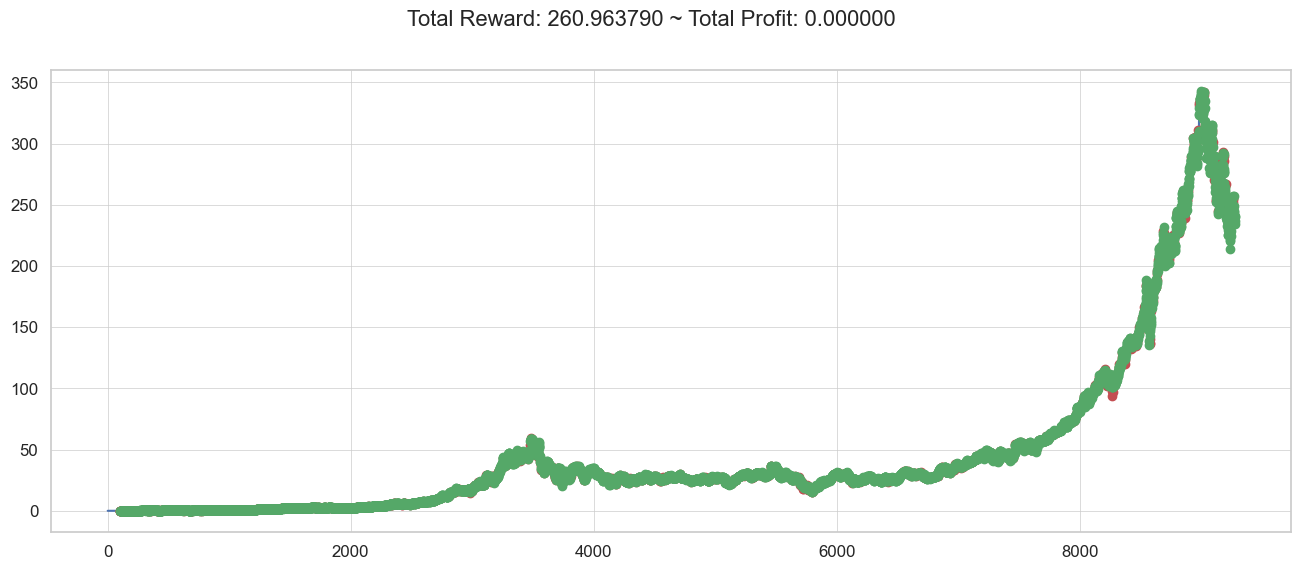

In [62]:
plt.figure(figsize=(16, 6))
env.unwrapped.render_all()
plt.show()

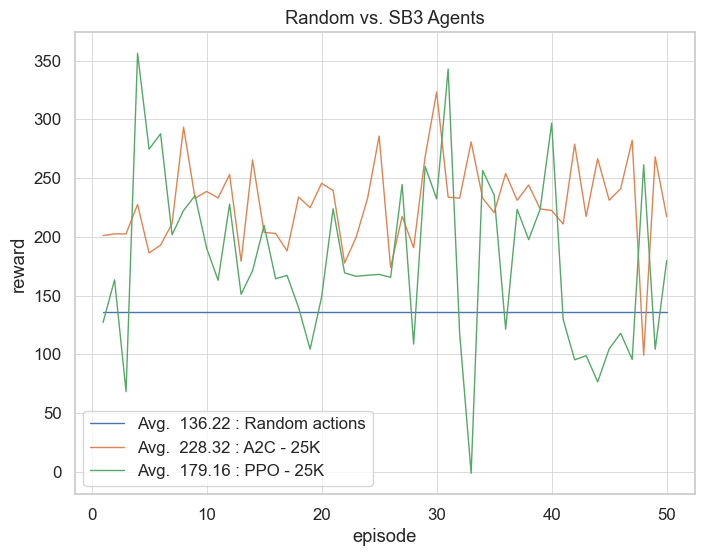

In [63]:
data = pd.DataFrame(plot_data)

sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))

for key in plot_data:
    if key == 'x':
        continue
    label = plot_settings[key]['label']
    line = plt.plot('x', key, data=data, linewidth=1, label=label)

plt.xlabel('episode')
plt.ylabel('reward')
plt.title('Random vs. SB3 Agents')
plt.legend()
plt.show()

In [64]:
### Analysis Using `quantstats`

In [79]:
stock = yf.Ticker("MSFT")
df = stock.history(period="max")

# window_size = 10
start_index = window_size
end_index = len(df)

In [80]:
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output='SB3_a2c_quantstats.html')

TypeError: 'NoneType' object is not subscriptable